<a href="https://colab.research.google.com/github/VelociraptorAndCo/Kozireva_Elizaveta/blob/main/resnet_finetune_for_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchsummary import summary

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, RandomApply, RandomRotation, RandomHorizontalFlip, GaussianBlur, RandomChoice
from torchvision.io import read_image

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle/"

https://www.kaggle.com/datasets/gpiosenka/100-bird-species

In [3]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [00:23<00:00, 85.1MB/s]
100% 1.96G/1.96G [00:23<00:00, 89.9MB/s]


In [4]:
! unzip 100-bird-species.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/WHITE TAILED TROPIC/120.jpg  
  inflating: train/WHITE TAILED TROPIC/121.jpg  
  inflating: train/WHITE TAILED TROPIC/122.jpg  
  inflating: train/WHITE TAILED TROPIC/123.jpg  
  inflating: train/WHITE TAILED TROPIC/124.jpg  
  inflating: train/WHITE TAILED TROPIC/125.jpg  
  inflating: train/WHITE TAILED TROPIC/126.jpg  
  inflating: train/WHITE TAILED TROPIC/127.jpg  
  inflating: train/WHITE TAILED TROPIC/128.jpg  
  inflating: train/WHITE TAILED TROPIC/129.jpg  
  inflating: train/WHITE TAILED TROPIC/130.jpg  
  inflating: train/WHITE TAILED TROPIC/131.jpg  
  inflating: train/WHITE TAILED TROPIC/132.jpg  
  inflating: train/WHITE TAILED TROPIC/133.jpg  
  inflating: train/WHITE TAILED TROPIC/134.jpg  
  inflating: train/WHITE TAILED TROPIC/135.jpg  
  inflating: train/WHITE TAILED TROPIC/136.jpg  
  inflating: train/WHITE TAILED TROPIC/137.jpg  
  inflating: train/WHITE TAILED TROPIC/138.jpg  
 

In [5]:
birds = pd.read_csv('birds.csv')
birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89885 entries, 0 to 89884
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class id         89885 non-null  float64
 1   filepaths        89885 non-null  object 
 2   labels           89885 non-null  object 
 3   data set         89885 non-null  object 
 4   scientific name  89885 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.4+ MB


In [ ]:
birds.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [6]:
birds[birds['data set']=='train'].groupby('labels').size().sort_values()#в test valid по 5 каждого

labels
EURASIAN GOLDEN ORIOLE     130
RED TAILED THRUSH          130
SNOWY PLOVER               130
AMETHYST WOODSTAR          130
PATAGONIAN SIERRA FINCH    130
                          ... 
ASIAN GREEN BEE EATER      220
D-ARNAUDS BARBET           233
OVENBIRD                   233
HOUSE FINCH                248
RUFOUS TREPE               263
Length: 525, dtype: int64

In [ ]:
def pictsize(path):
  pict = plt.imread(path)
  return pict.shape
pictsize('train/OVENBIRD/014.jpg')

(224, 224, 3)

In [7]:
birds.loc[birds['class id']==373, 'filepaths'] = birds.loc[birds['class id']==373, 'filepaths'].map(lambda x: x.split('/')[0] + '/PARAKETT  AUKLET/'+x.split('/')[-1])#+rename valid to have __

In [ ]:
birds['size'] = birds['filepaths'].map(pictsize)

In [ ]:
birds.groupby('size')['filepaths'].nunique()[birds.groupby('size')['filepaths'].nunique() != 1]

In [ ]:
dr = np.arange(len(birds))[birds['size']!=(224, 224, 3)]
dr

array([51532, 60654, 60655, 60656, 60657, 60658, 60659, 60660, 60661,
       60662, 60663, 60664, 60665, 60666, 60667, 60668, 60669, 60670,
       60671, 60672, 60673, 60674, 60675, 60676, 60677, 60678, 60679,
       60680, 60681, 60682, 60683, 60684, 60685, 60686, 60687, 60688,
       60689, 60690, 60691, 60692, 60693, 60694, 60695, 60696, 60697,
       60698, 60699, 60700, 60701, 60702, 60703, 60704, 60705, 60706,
       60707, 60708, 60709, 60710, 60711, 60712, 60713, 60714, 60715,
       60716, 60717, 60718, 60719, 60720, 60721, 60722, 60723, 60724,
       60725, 60726, 60727, 60728, 60729, 60730, 60731, 60732, 60733,
       60734, 60735, 60736, 60737, 60738, 60739, 60740, 60741, 60742,
       60743, 60744, 60745, 60746, 60747, 60748, 60749, 60750, 60751,
       60752, 60753, 60754, 60755, 60756, 60757, 60758, 60759, 60760,
       60761, 60762, 60763, 60764, 60765, 60766, 60767, 60768, 60769,
       60770, 60771, 60772, 60773, 60774, 60775, 60776, 60777, 60778,
       60779, 60780,

In [8]:
dr = [51532, 60654, 60655, 60656, 60657, 60658, 60659, 60660, 60661,
       60662, 60663, 60664, 60665, 60666, 60667, 60668, 60669, 60670,
       60671, 60672, 60673, 60674, 60675, 60676, 60677, 60678, 60679,
       60680, 60681, 60682, 60683, 60684, 60685, 60686, 60687, 60688,
       60689, 60690, 60691, 60692, 60693, 60694, 60695, 60696, 60697,
       60698, 60699, 60700, 60701, 60702, 60703, 60704, 60705, 60706,
       60707, 60708, 60709, 60710, 60711, 60712, 60713, 60714, 60715,
       60716, 60717, 60718, 60719, 60720, 60721, 60722, 60723, 60724,
       60725, 60726, 60727, 60728, 60729, 60730, 60731, 60732, 60733,
       60734, 60735, 60736, 60737, 60738, 60739, 60740, 60741, 60742,
       60743, 60744, 60745, 60746, 60747, 60748, 60749, 60750, 60751,
       60752, 60753, 60754, 60755, 60756, 60757, 60758, 60759, 60760,
       60761, 60762, 60763, 60764, 60765, 60766, 60767, 60768, 60769,
       60770, 60771, 60772, 60773, 60774, 60775, 60776, 60777, 60778,
       60779, 60780, 60781, 60782, 60783, 60784, 60785, 60786, 60787,
       60788, 60789, 60790, 60791, 60792, 60793, 60794, 60795, 60796,
       60797, 60798, 60799, 60800, 60801, 60802, 60803, 60804, 60805,
       60806, 60807, 60808, 60809, 60810, 60811, 60812, 60813, 60814,
       60815, 60816, 60817, 60818, 60819, 60820, 60821, 60822, 60823,
       60824, 60825, 60826, 60827, 60828, 60829, 60830, 60831, 60832,
       60833, 60834, 60835, 60836, 60837, 60838, 60839, 60840, 60841,
       60842, 60843, 60844, 60845, 60846, 60847, 60848, 60849, 60850,
       60851, 60852, 60853, 86540, 86541, 86542, 86543, 86544, 89165,
       89166, 89167, 89168, 89169]

In [9]:
birds = birds.drop(dr)

In [10]:
group = birds.groupby('data set')
dfs = {x: group.get_group(x).drop('data set', axis = 1).reset_index() for x in ['test', 'train', 'valid']}
group['class id'].nunique()

data set
test     524
train    524
valid    524
Name: class id, dtype: int64

In [11]:
labels = [x[0] for x in birds.groupby('class id')['labels'].unique()]
labels

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN ROBIN',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'ASIAN GREEN BEE EATER',
 'ASIAN OPENBILL STORK',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE BREASTED PITTA',
 'A

теперь делаем датасет

In [12]:
#class_amount = 525
class birdsdata(Dataset):

    def __init__(self, df, transform=None):
        """
        Args:
            csv_file (string): Путь к CSV-файлу с разметкой.
            root_dir (string): Корневая директория c изображениями.
            transform (callable, optional): Необязательные трансформации, применяемые к изображениями.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.df.loc[idx, 'filepaths']
        image = read_image(img_name)#torch.Size([3, 224, 224])
        cl = int(self.df.loc[idx, 'class id'])
        sample = {'image': image/256, 'label': torch.tensor(cl)}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [13]:
trs = Compose([ RandomApply([RandomHorizontalFlip()]), RandomApply([GaussianBlur(kernel_size=(5, 9))])])

In [14]:
ds = { x: birdsdata(dfs[x]) for x in ['test', 'valid']}
ds['train'] = birdsdata(dfs['train'], trs)

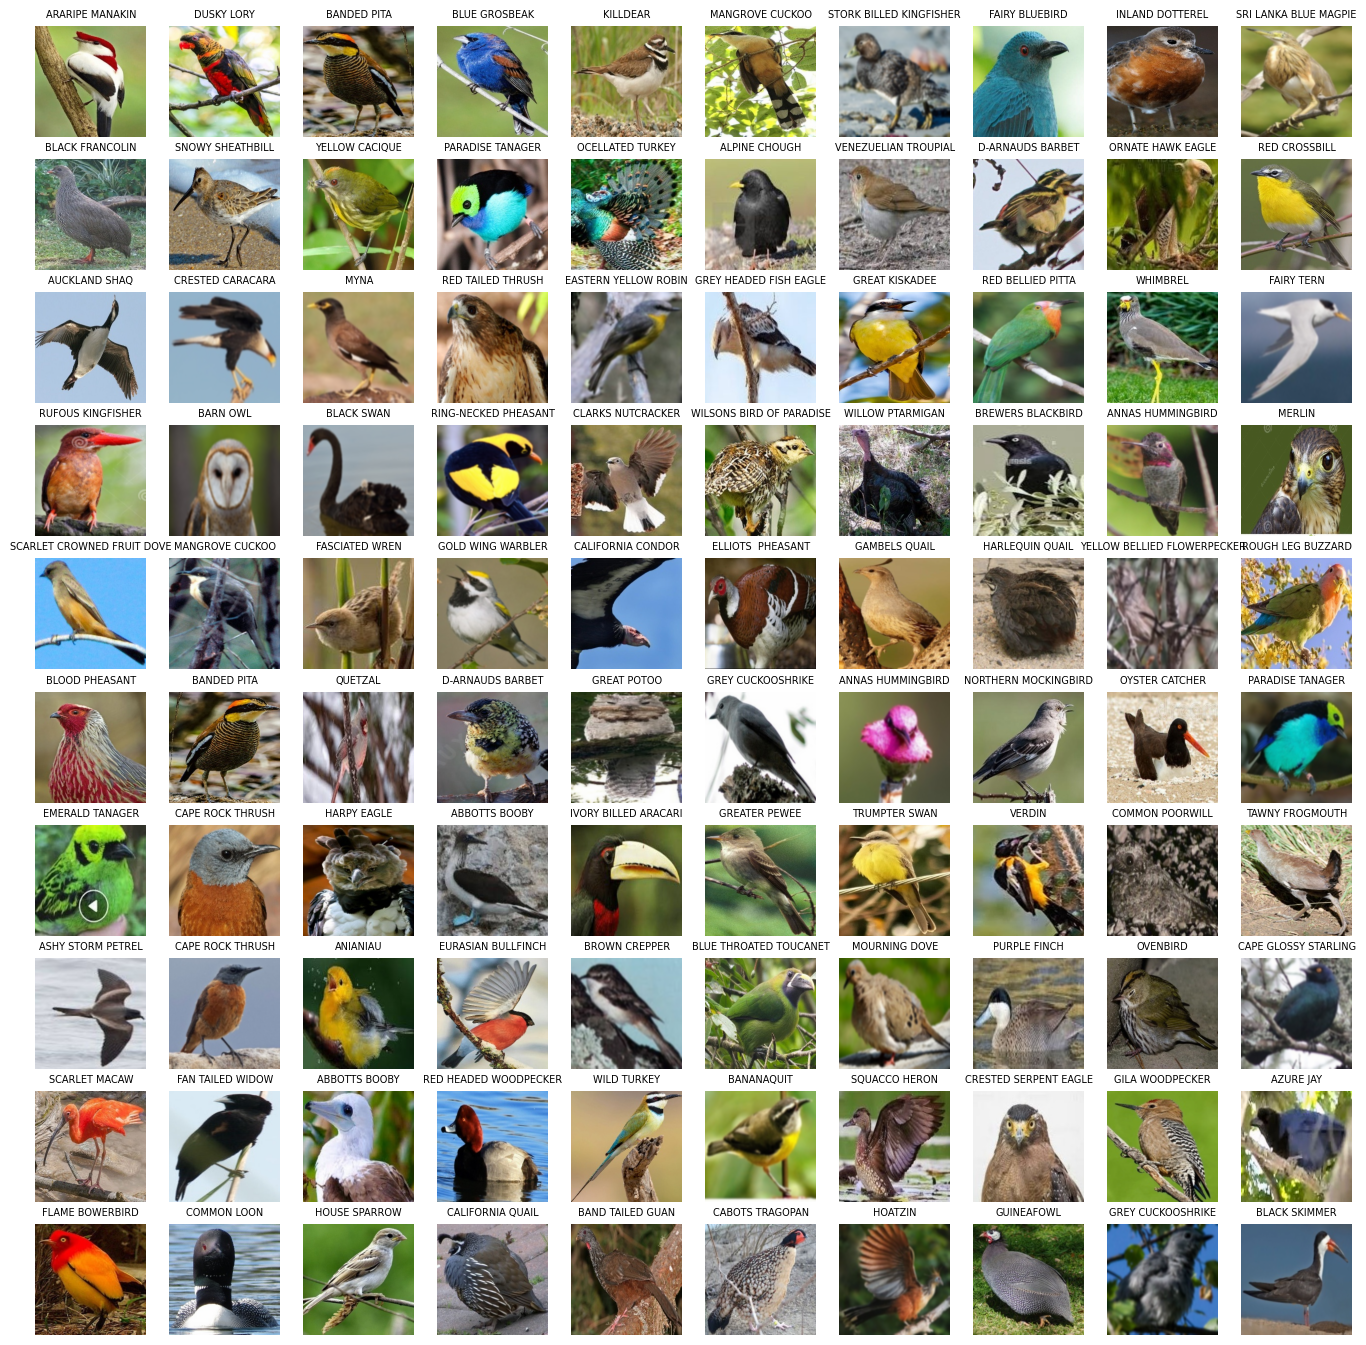

In [15]:
figure = plt.figure(figsize=(17, 17))
cols, rows = 10, 10
''''''
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds['train']), size=(1,)).item() # Случайный индекс из датасета
    sample = ds['train'][sample_idx] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    label = int(sample['label'])
    plt.title(labels[label], fontsize = 7)
    plt.axis("off")
    plt.imshow(np.moveaxis(sample['image'].numpy(),0,-1))
    #print(sample['image'].shape)
plt.show()

In [16]:
dataloaders = {x: DataLoader(ds[x], batch_size=32, shuffle=True) for x in ['train', 'valid', 'test']}

#finetune of resnet50

In [ ]:
from torchvision.models import resnet50

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
model = resnet50(weights='DEFAULT').to(device)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=525, bias=True).to(device)#fullyconnected is .fc

In [ ]:
#data to divice!!!

def train_loop(dataloader, model, loss_fn, optimizer, lss_train):
    size = len(dataloader.dataset)
    for batch, sample in enumerate(dataloader):
        #move
        X = sample['image'].to(device)
        y = sample['label'].to(device)
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            lss_train.append(loss)

def test_loop(dataloader, model, loss_fn, accs, lss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample in dataloader:
            #move
            X = sample['image'].to(device)
            y = sample['label'].to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accs.append(100*correct)
    lss.append(test_loss)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = .01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
print(f"1")
train_loop(dataloaders['train'], model, loss_fn, optimizer, [])

1
loss: 6.282509  [    0/84434]
loss: 1.213797  [25600/84434]
loss: 0.873368  [51200/84434]
loss: 0.968710  [76800/84434]


In [ ]:
torch.save(model.state_dict(), f"drive/MyDrive/birds/finetuned00.pt")

In [ ]:
learning_rate = .003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3,4], gamma=0.1)
epochs = 3
lss_train = []
lss = []
accs = []
for t in range(epochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(dataloaders['train'], model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(dataloaders['valid'], model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/birds/finetuned{t}.pt")
    scheduler.step()
print("Done!")

Epoch 0
-------------------------------
loss: 0.461278  [    0/84434]
loss: 0.451235  [25600/84434]
loss: 0.280081  [51200/84434]
loss: 0.348392  [76800/84434]
Test Error: 
 Accuracy: 90.9%, Avg loss: 0.376684 

Epoch 1
-------------------------------
loss: 0.255548  [    0/84434]
loss: 0.191034  [25600/84434]
loss: 0.160496  [51200/84434]
loss: 0.118981  [76800/84434]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.352155 

Epoch 2
-------------------------------
loss: 0.092117  [    0/84434]
loss: 0.167384  [25600/84434]
loss: 0.125829  [51200/84434]
loss: 0.109335  [76800/84434]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.311008 

Done!


In [ ]:
#раз уж на то пошло, то давай в разнос пойдем
a = 0
for name, param in model.named_parameters():
  if name[5]=='4':
    a = 1
  if a:
    param.requires_grad = True

In [ ]:
#за одну эпоху научился, нехило так
learning_rate = .00003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3,4], gamma=0.03)
epochs = 5
lss_train = []
lss = []
accs = []
for t in range(epochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(dataloaders['train'], model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(dataloaders['valid'], model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/birds/finetuned{t}.pt")
    scheduler.step()
print("Done!")

Epoch 0
-------------------------------
loss: 0.158740  [    0/84434]
loss: 0.140239  [25600/84434]
loss: 0.067598  [51200/84434]
loss: 0.084373  [76800/84434]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.214216 

Epoch 1
-------------------------------
loss: 0.069624  [    0/84434]
loss: 0.042134  [25600/84434]
loss: 0.043713  [51200/84434]
loss: 0.070323  [76800/84434]
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.217703 

Epoch 2
-------------------------------
loss: 0.052987  [    0/84434]
loss: 0.041464  [25600/84434]
loss: 0.036261  [51200/84434]
loss: 0.043063  [76800/84434]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.234780 

Epoch 3
-------------------------------
loss: 0.107191  [    0/84434]
loss: 0.070189  [25600/84434]
loss: 0.048118  [51200/84434]
loss: 0.068123  [76800/84434]
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.218913 

Epoch 4
-------------------------------
loss: 0.038486  [    0/84434]
loss: 0.020997  [25600/84434]
loss: 0.060925  [51200/84434]
loss: 0.043147  [76800

In [ ]:
model = model.eval().to(device)
state_dict = torch.load(f"drive/MyDrive/birds/finetuned{2}.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
#глянуть парамы
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)#, param.data)

#my model

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [18]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()

        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, groups=5, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        return self.act(out + x)

class Bottleneck(nn.Module):
    def __init__(self, nc, neckc):
        super().__init__()

        self.act = nn.LeakyReLU(0.2)
        self.conv0 = nn.Conv2d(nc, neckc, kernel_size=1, padding=0)
        self.norm0 = nn.BatchNorm2d(neckc)
        self.conv1 = nn.Conv2d(neckc, neckc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(neckc)
        self.conv2 = nn.Conv2d(neckc, nc, kernel_size=1, padding=0)
        self.norm2 = nn.BatchNorm2d(nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)
        return self.act(out + x)

class ArcSkip(nn.Module):
    def __init__(self, nc):
        super().__init__()

        self.conv0 = nn.Conv2d(nc, nc, kernel_size=5, groups=5, padding=2)#чтоб параметров меньше группы поставлю: карт много и мешаются в процессе groups=2,
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(nc, nc, kernel_size=3, groups=5, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.norm1 = nn.BatchNorm2d(nc)
        self.norm2 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2)


    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        sk1 = self.act(out)

        out = self.conv1(sk1)
        out = self.norm1(out)
        out = self.act(out)

        out = self.conv2(sk1+out)
        out = self.norm2(out)
        return self.act(out + x)

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=35, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=False),
            nn.BatchNorm2d(35),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            #torch.Size([1, 35, 112, 112])
            ArcSkip(35),
            nn.Dropout(p=0.1),
            ResBlock(35),
            ArcSkip(35),
            ResBlock(35),
            ArcSkip(35),
            ResBlock(35),
            ArcSkip(35),

            nn.Conv2d(in_channels=35, out_channels=70, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=False),
            nn.BatchNorm2d(70),
            nn.ReLU(),
            #torch.Size([1, 70, 56, 56])
            ResBlock(70),

            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 70, 28, 28])
            ArcSkip(70),

            nn.Conv2d(in_channels=70, out_channels=105, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=False),
            nn.BatchNorm2d(105),
            nn.ReLU(),
            #torch.Size([1, 105, 14, 14])
            ResBlock(105),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 105, 7, 7])
            ResBlock(105),
            nn.MaxPool2d(kernel_size = (2, 2)),
            #torch.Size([1, 105, 3, 3])
            nn.Flatten()
        )
        self.hat = nn.Linear(105*9, 525)



    def forward(self, x):
        x = self.linear_stack(x)
        logits = self.hat(x)
        return logits

In [ ]:
sh = (1, 105, 2, 2)
lay = nn.Conv2d(in_channels=105, out_channels=525, kernel_size=(2, 2), stride=1, padding=0, groups=5, bias=False)
x = torch.rand(*sh)
a = lay(x)
print(a.shape)

torch.Size([1, 525, 1, 1])


In [20]:
model = NeuralNetwork().to(device)

In [ ]:
summary(model, (3, 224, 224))

In [ ]:
#if works with our data
X = torch.rand(1, 3, 224, 224, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
y = y_pred.cpu().numpy()[0]
del pred_probab, y_pred, logits
print(f"Predicted class: {y}, {labels[y]}")
del X,y

Predicted class: 192, DUSKY ROBIN


#training

In [23]:
model.hat = nn.Linear(105*9, 525).to(device)

In [ ]:
#load and check
model = NeuralNetwork().eval().to(device)
state_dict = torch.load("drive/MyDrive/birds/bird00.pt")
model.load_state_dict(state_dict)

#test_loop(test_dataloader, new_model, loss_fn)

In [24]:
loss_fn = nn.CrossEntropyLoss()

In [25]:
#data to divice!!!

def train_loop(dataloader, model, loss_fn, optimizer, lss_train):
    size = len(dataloader.dataset)
    for batch, sample in enumerate(dataloader):
        #move
        X = sample['image'].to(device)
        y = sample['label'].to(device)
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            lss_train.append(loss)
        del X,y,sample

def test_loop(dataloader, model, loss_fn, accs, lss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample in dataloader:
            #move
            X = sample['image'].to(device)
            y = sample['label'].to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            del X,y

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accs.append(100*correct)
    lss.append(test_loss)


In [26]:
torch.save(model.state_dict(), f"drive/MyDrive/birds/bird00.pt")

In [29]:
learning_rate = .003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-80)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3,4], gamma=0.2)
epochs = 5
lss_train = []
lss = []
accs = []
for t in range(epochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(dataloaders['train'], model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(dataloaders['valid'], model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/birds/bird{t}.pt")
    scheduler.step()
print("Done!")

Epoch 0
-------------------------------
loss: 4.060574  [    0/84434]
loss: 2.582798  [ 3200/84434]
loss: 2.803883  [ 6400/84434]
loss: 2.507858  [ 9600/84434]
loss: 2.757179  [12800/84434]
loss: 2.387413  [16000/84434]
loss: 2.550658  [19200/84434]
loss: 2.180800  [22400/84434]
loss: 2.483848  [25600/84434]
loss: 2.654258  [28800/84434]
loss: 3.235658  [32000/84434]
loss: 2.070683  [35200/84434]
loss: 3.703594  [38400/84434]
loss: 2.807943  [41600/84434]
loss: 2.427194  [44800/84434]
loss: 2.517501  [48000/84434]
loss: 2.639627  [51200/84434]
loss: 2.408835  [54400/84434]
loss: 3.501619  [57600/84434]
loss: 2.904319  [60800/84434]
loss: 2.969091  [64000/84434]
loss: 2.355549  [67200/84434]
loss: 1.952158  [70400/84434]
loss: 2.745687  [73600/84434]
loss: 3.279568  [76800/84434]
loss: 2.427555  [80000/84434]
loss: 2.637393  [83200/84434]
Test Error: 
 Accuracy: 51.0%, Avg loss: 2.235814 

Epoch 1
-------------------------------
loss: 2.528557  [    0/84434]
loss: 2.316984  [ 3200/84434

In [30]:
learning_rate = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-70)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,4], gamma=0.06)

In [ ]:
newepochs = 5
for t in range(epochs, epochs+newepochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(dataloaders['train'], model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(dataloaders['valid'], model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/birds/bird{t}.pt")
    scheduler.step()
print("Done!")
epochs+=newepochs

Epoch 5
-------------------------------
loss: 2.984362  [    0/84434]
loss: 1.384773  [ 3200/84434]
loss: 2.476731  [ 6400/84434]
loss: 1.932813  [ 9600/84434]
loss: 2.076053  [12800/84434]
loss: 1.796430  [16000/84434]
loss: 2.448806  [19200/84434]
loss: 1.748132  [22400/84434]
loss: 1.940073  [25600/84434]
loss: 2.897653  [28800/84434]
loss: 2.455133  [32000/84434]
loss: 2.529240  [35200/84434]
loss: 2.600092  [38400/84434]
loss: 1.733497  [41600/84434]
loss: 2.815684  [44800/84434]
loss: 2.101434  [48000/84434]
loss: 1.930803  [51200/84434]
loss: 2.130963  [54400/84434]
loss: 2.380166  [57600/84434]
loss: 1.692088  [60800/84434]
loss: 2.087102  [64000/84434]
loss: 2.209590  [67200/84434]
loss: 1.635615  [70400/84434]
loss: 1.822402  [73600/84434]
loss: 1.762353  [76800/84434]
loss: 2.426980  [80000/84434]
loss: 2.306695  [83200/84434]
Test Error: 
 Accuracy: 54.3%, Avg loss: 2.089426 

Epoch 6
-------------------------------
loss: 1.896867  [    0/84434]
loss: 2.303643  [ 3200/84434

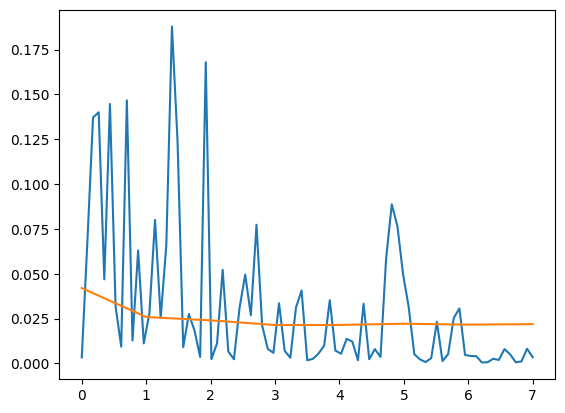

In [ ]:
plt.plot(np.linspace(0, len(lss)-1, len(lss_train)), lss_train)
plt.plot(range(len(lss)), lss)

#np.savetxt("/content/drive/MyDrive/ShapesDetector/shapes/losses.txt", np.array(lss))
#plt.title("loss")
#plt.savefig("/content/drive/MyDrive/ShapesDetector/shapes/loss.png")
plt.show()

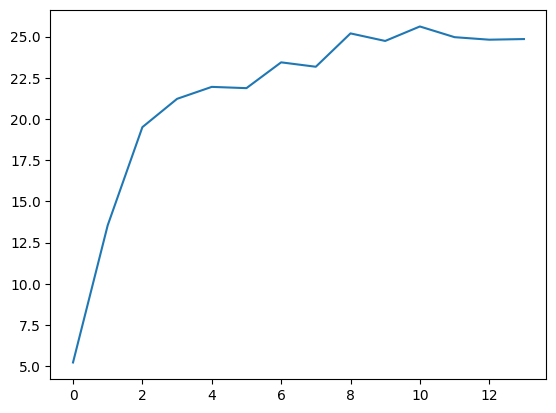

In [ ]:
plt.plot(range(len(lss)), accs)
plt.show()

#pretrain on CIFAR100


In [ ]:
from torchvision import datasets
from torchvision.transforms import Resize

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), trs])
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


#MNIST
def train_loop(dataloader, model, loss_fn, optimizer, lss_train):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #move
        X = Resize((224, 224))(X)
        X = torch.stack([X]*3)
        X = X.transpose(0,2)
        X = X[0]
        X = X.to(device)
        y = y.to(device)
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            lss_train.append(loss)

def test_loop(dataloader, model, loss_fn, accs, lss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            #move
            X = Resize((224, 224))(X)
            X = torch.stack([X]*3)
            X = X.transpose(0,2)
            X = X[0]
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accs.append(100*correct)
    lss.append(test_loss)


#change hat
model.hat = nn.Linear(105*9, 10).to(device)
#print(model)

In [ ]:
training_data = datasets.CIFAR100(#MNIST такой же
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), trs])
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
#data to divice!!!

def train_loop(dataloader, model, loss_fn, optimizer, lss_train):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #move
        X = Resize((224, 224))(X)
        X = X.to(device)
        y = y.to(device)
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            lss_train.append(loss)

def test_loop(dataloader, model, loss_fn, accs, lss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            #move
            X = Resize((224, 224))(X)
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accs.append(100*correct)
    lss.append(test_loss)

In [21]:
#change hat
model.hat = nn.Linear(105*9, 100).to(device)

In [ ]:
summary(model, (3, 224, 224))

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
learning_rate = .01 #мнист только эту ячейку
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-70)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3,4], gamma=0.2)
epochs = 5
lss_train = []
lss = []
accs = []
for t in range(epochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/birds/notabird{t}.pt")
    scheduler.step()
print("Done!")

Epoch 0
-------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


loss: 4.640687  [    0/50000]
loss: 4.665035  [ 1280/50000]
loss: 4.474777  [ 2560/50000]
loss: 4.337119  [ 3840/50000]
loss: 4.330503  [ 5120/50000]
loss: 4.205172  [ 6400/50000]
loss: 3.938154  [ 7680/50000]
loss: 4.256668  [ 8960/50000]
loss: 3.721962  [10240/50000]
loss: 3.859393  [11520/50000]
loss: 3.781987  [12800/50000]
loss: 3.503894  [14080/50000]
loss: 4.024667  [15360/50000]
loss: 3.584883  [16640/50000]
loss: 3.648415  [17920/50000]
loss: 3.486027  [19200/50000]
loss: 3.918065  [20480/50000]
loss: 3.278093  [21760/50000]
loss: 4.013923  [23040/50000]
loss: 3.436110  [24320/50000]
loss: 3.458556  [25600/50000]
loss: 3.969565  [26880/50000]
loss: 3.526249  [28160/50000]
loss: 3.666636  [29440/50000]
loss: 3.382923  [30720/50000]
loss: 3.148726  [32000/50000]
loss: 3.595968  [33280/50000]
loss: 3.006356  [34560/50000]
loss: 3.360512  [35840/50000]
loss: 3.003496  [37120/50000]
loss: 3.673481  [38400/50000]
loss: 3.050074  [39680/50000]
loss: 3.434438  [40960/50000]
loss: 3.26

In [ ]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-60)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1,2,3,4,5], gamma=0.0735)
newepochs = 6
for t in range(epochs, epochs+newepochs):
    print(f"Epoch {t}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer, lss_train)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, accs, lss)
    torch.save(model.state_dict(), f"drive/MyDrive/birds/notabird{t}.pt")
    scheduler.step()
print("Done!")
epochs+=newepochs

Epoch 5
-------------------------------
loss: 2.159279  [    0/50000]
loss: 2.255004  [ 1280/50000]
loss: 2.456679  [ 2560/50000]
loss: 2.528858  [ 3840/50000]
loss: 2.179719  [ 5120/50000]
loss: 2.192692  [ 6400/50000]
loss: 2.587567  [ 7680/50000]
loss: 2.504725  [ 8960/50000]
loss: 2.611490  [10240/50000]
loss: 2.365367  [11520/50000]
loss: 2.056097  [12800/50000]
loss: 2.206099  [14080/50000]
loss: 2.637433  [15360/50000]
loss: 2.512391  [16640/50000]
loss: 2.529666  [17920/50000]
loss: 2.803253  [19200/50000]
loss: 1.969213  [20480/50000]
loss: 2.059712  [21760/50000]
loss: 2.566713  [23040/50000]
loss: 2.214981  [24320/50000]
loss: 2.742778  [25600/50000]
loss: 2.389802  [26880/50000]
loss: 2.431123  [28160/50000]
loss: 2.293523  [29440/50000]
loss: 2.417810  [30720/50000]
loss: 2.051026  [32000/50000]
loss: 2.646916  [33280/50000]
loss: 2.666460  [34560/50000]
loss: 2.023488  [35840/50000]
loss: 2.562185  [37120/50000]
loss: 2.541203  [38400/50000]
loss: 1.929766  [39680/50000]


In [ ]:
summary(model, (3, 224, 224))

In [22]:
model = model.eval().to(device)
state_dict = torch.load(f"drive/MyDrive/birds/notabird{10}.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
plt.plot(np.linspace(0, len(lss)-1, len(lss_train)), lss_train)
plt.plot(range(len(lss)), lss)

#np.savetxt("/content/drive/MyDrive/ShapesDetector/shapes/losses.txt", np.array(lss))
#plt.title("loss")
#plt.savefig("/content/drive/MyDrive/ShapesDetector/shapes/loss.png")
plt.show()

#что то попло не так

In [ ]:
del training_data
del test_data
del train_dataloader
del test_dataloader
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4283 KiB |   4283 KiB |   4283 KiB |      0 B   |
|       from large pool |   1938 KiB |   1938 KiB |   1938 KiB |      0 B   |
|       from small pool |   2345 KiB |   2345 KiB |   2345 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |   4283 KiB |   4283 KiB |   4283 KiB |      0 B   |
|       from large pool |   1938 KiB |   1938 KiB |   1938 KiB |

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  13657 MiB |  13658 MiB |  16662 MiB |   3004 MiB |
|       from large pool |  13655 MiB |  13655 MiB |  16656 MiB |   3001 MiB |
|       from small pool |      2 MiB |      2 MiB |      5 MiB |      3 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  13657 MiB |  13658 MiB |  16662 MiB |   3004 MiB |
|       from large pool |  13655 MiB |  13655 MiB |  16656 MiB |

In [ ]:
# prints currently alive Tensors and Variables from garbage collector list
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass